In [3]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [5]:
df = pd.read_csv("IMDB.csv")

In [7]:
def styled_heading(text, background_color='#0077b6', text_color='white'):
    return f"""
    <p style="
        background-color: {background_color};
        font-family: Arial, sans-serif;
        font-size: 20px;
        font-weight: bold;
        color: {text_color};
        text-align: center;
        border-radius: 8px;
        padding: 12px;
        box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.2);
        width: fit-content;
        margin: 10px auto;
    ">
        {text}
    </p>
    """
def style_table(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("color", "white"), ("background-color", "#0077b6"), ("padding", "10px")]},
        {"selector": "td", "props": [("text-align", "center"), ("padding", "8px")]} 
    ]).set_properties(**{"border": "1px solid #ddd"}).hide(axis="index").to_html()

def print_dataset_analysis(df, n_top=5, heading_color='#0077b6', text_color='white'):
    display(HTML(styled_heading("📊 Basic Overview of Data", heading_color, text_color)))
    display(HTML(style_table(df.head(n_top))))
    
    display(HTML(styled_heading("🚫 Missing Values", heading_color, text_color)))
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        display(HTML("<p style='text-align:center; font-weight:bold;'>✅ No missing values in the dataset.</p>"))
    else:
        display(HTML(style_table(null_counts[null_counts > 0].to_frame(name='Missing Count'))))
    
    display(HTML(styled_heading("♻️ Duplicate Records", heading_color, text_color)))
    duplicates = df.duplicated().sum()
    display(HTML(f"<p style='text-align:center; font-weight:bold;'>🔄 {duplicates} duplicate rows found.</p>"))
    
    display(HTML(styled_heading("📏 Dataset Shape", heading_color, text_color)))
    display(HTML(f"<p style='text-align:center; font-weight:bold;'>Rows: {df.shape[0]}, Columns: {df.shape[1]}</p>"))

def print_value_counts(df, target_column, heading_color='#0077b6', text_color='white'):
    display(HTML(styled_heading("🔢 Value Counts", heading_color, text_color)))
    if target_column in df.columns:
        value_counts = df[target_column].value_counts()
        formatted_counts = "".join(f"<p style='text-align:center; font-weight:bold;'>{index}: {count}</p>" for index, count in value_counts.items())
        display(HTML(formatted_counts))
    else:
        display(HTML(f"<p style='text-align:center; font-weight:bold; color:red;'>⚠️ Column '{target_column}' not found in dataset.</p>"))

print_dataset_analysis(df,n_top=5)
print_value_counts(df,'sentiment')

review,sentiment
"Starts really well, nice intro and build up for the main characters but after about 5 minutes, the charm is lost.The character is in the same mould as the main protagonist from American Pie and Loser without the supporting cast or innovative storyline that made the Pie movies more of a commercial success.Let's be honest - Heder's acting was pretty poor. Keaton, Daniels and Faris did their best but had no substantial plot or script to get their teeth into The movie just plods on without any pace or clear logical storyline justifying its length.The ending is about as predictable as they come - so predictable I've ticked the spoilers box for this one line.My advice: avoid at all costs unless you really really have nothing else to do/listen to or watch and even then you'll feel the producers just cheated you out of an hour and a half of your life.",negative
"Terrific movie: If you did not watch yet, you must watch. Geena Davis and Samuel L. Jackson are amazing in this movie.Great actors + good story + incredible action scenes > ""The Long Kiss Goodnight"" I give it a 10, A+, 4 stars.",positive
"I've seen hundreds of silent movies. Some will always be classics (such as Nosferatu, Metropolis, The General and Wings) but among them, my favorite is this film (it may not be the best--but a favorite, yes). In fact, when I looked it up on IMDb, I noticed I immediately laughed to myself because the movie was so gosh-darn cute and well-made. Marion Davies proved with this movie she really had great talent and was not JUST William Randolph Hearst's mistress.The story involves a hick from Georgia coming to Hollywood with every expectation that she would be an instant star! Her experiences and the interesting cameos of stars of the era make this a real treat for movie buffs and a must-see!",positive
"i had been looking for this film for so long before i found it, i had seen it when i was younger and loved it, after my second viewing i still loved it and i still do.this is a love/hate film, if you like bottom, young ones, the comic strip, then you will find this funny. If you don't like that kind of humour then don't bother. I love this film and have grown up with these comedy programmes, for me this film is simply placing their comic genius on the big screen.. It is not an award winner by any means but if you just want good wholesome slapstick then this is it!the film lacks the quality of the TV series and this is usually the case with films but it still has enough material to keep you laughing even if a lot of the jokes are pretty similar to their previous work.yes, the humour is a little childish and not to everyone's taste but sometimes you just need that in a film.",positive
"Good: Engaging cinematic firefights, great presentation, vehicles are actually fun to drive, fairly appealing multiplayer, faithful to the movie, and the list goes on.Bad: Main missions are a bit short.This game defines what a ""good"" third person shooter(not necessarily a spy-game) is. Great firefights carry on the story and make you want to complete EVERY single mission through, and unlock all the genuine bonuses the game has to offer. The hype this game had, was lived up to, and I personally think you should buy it, and hook up with a couple of friends and play this one. Loads of fun. The sound in this game, is a rip-roaring achievement from a few previous bond games, and firing a weapon, really feels like you're firing a weapon. It ties in with the aspect that you are a deadly and ruthless spy.All in all, this game makes you excited and satisfied after you make it through, and some multiplayer that can compete with the standards of the crafty James Bond ""Nightfire"" game for gamecube.",positive


In [9]:
df=df.drop_duplicates()

In [11]:
# stop words to be removed later
custom_stopwords = set(stopwords.words('english'))  
# Make sure 'review' is a valid column name
print(df.columns)

Index(['review', 'sentiment'], dtype='object')


In [13]:
def preprocess_text(text):
    if isinstance(text, str):  # Ensure text is a string
        ## REMOVE HTML
        if "<" in text and ">" in text:
            text = BeautifulSoup(text, "html.parser").get_text()
        ## CLEANING
        # Remove special characters
        text = re.sub(r'\W+', ' ', text)  
        # Remove digits
        text = re.sub(r'\d+', '', text)
        ## LOWERCASING
        text = text.lower()
        ## TOKENIZATION
        words = text.split()
        ## REMOVE STOPWORDS
        words = [w for w in words if w not in custom_stopwords] 
        ## APPLY LEMMATIZATION
        words = [lemmatizer.lemmatize(w) for w in words]
        ## RETURN CLEANED TEXT
        return ' '.join(words)
    return ""
# Apply preprocessing
df['processed_review'] = df['review'].apply(preprocess_text)
# Show original vs processed text
print(df[['review', 'processed_review']].head(10))  

                                              review  \
0  Starts really well, nice intro and build up fo...   
1  Terrific movie: If you did not watch yet, you ...   
2  I've seen hundreds of silent movies. Some will...   
3  i had been looking for this film for so long b...   
4  Good: Engaging cinematic firefights, great pre...   
5  I say this. If you want to see art, you go to ...   
6  Hey, it's only TV. Sure, it's STAR TREK, the m...   
7  this movie has lot of downsides and thats all ...   
8  How can you tell that a horror movie is terrib...   
9  Brian De Palma's undeniable virtuosity can't r...   

                                    processed_review  
0  start really well nice intro build main charac...  
1  terrific movie watch yet must watch geena davi...  
2  seen hundred silent movie always classic nosfe...  
3  looking film long found seen younger loved sec...  
4  good engaging cinematic firefights great prese...  
5  say want see art go art gallery want see movie... 

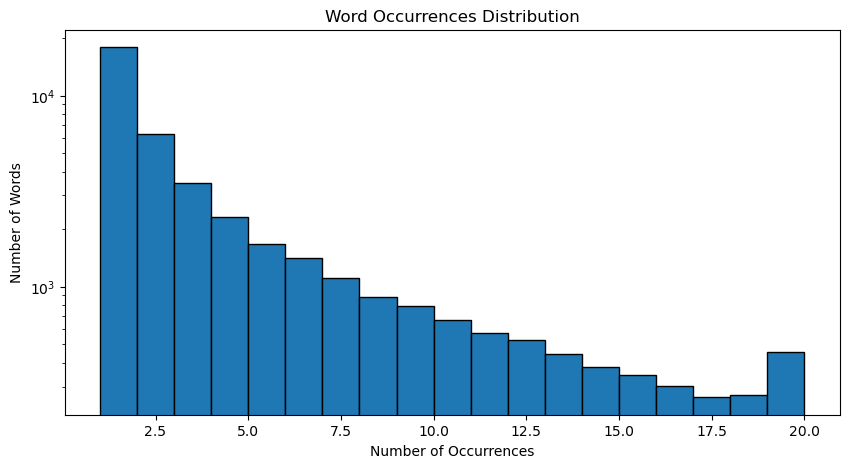

In [15]:
# BAG OF WORDS ASSUMPTION
word_counts = Counter(" ".join(df["processed_review"]).split())
# Get word frequencies
occurrences_values = list(word_counts.values())

# Plot histogram to help decide the threshold that will be used to remove rare words later
# threshold here is the minimum number of occurrences for one word so that it will not be considered as a rare word
plt.figure(figsize=(10, 5))
plt.hist(occurrences_values, bins=range(1, 21), edgecolor='black')  # Only show words appearing ≤ 20 times 
plt.yscale('log')  # Log scale helps visualize better
plt.xlabel("Number of Occurrences")
plt.ylabel("Number of Words")
plt.title("Word Occurrences Distribution")
plt.show()

In [19]:
## REMOVE RARE WORDS
# Most words appear very few times (1-5 occurrences)
# The count drops significantly as frequency increases  
# we will take a threshold of 4 which Keeps moderately rare words that might still carry meaning but Removes very infrequent words that could add noise

threshold = 4
# Identify rare words
rare_words = {w for w, c in word_counts.items() if c <= threshold}  

def remove_rare_words(text):
    if isinstance(text, str):  # Ensure text is a string
        words = text.split()
        return ' '.join([w for w in words if w not in rare_words])
    return ""

# Apply to dataset
df['processed_review2'] = df['processed_review'].apply(remove_rare_words)

# Check results
print(df[['processed_review', 'processed_review2']].head(10))

                                    processed_review  \
0  start really well nice intro build main charac...   
1  terrific movie watch yet must watch geena davi...   
2  seen hundred silent movie always classic nosfe...   
3  looking film long found seen younger loved sec...   
4  good engaging cinematic firefights great prese...   
5  say want see art go art gallery want see movie...   
6  hey tv sure star trek beloved bla bla great on...   
7  movie lot downside thats could see painfully l...   
8  tell horror movie terrible stop laughing cours...   
9  brian de palma undeniable virtuosity really ca...   

                                   processed_review2  
0  start really well nice intro build main charac...  
1  terrific movie watch yet must watch geena davi...  
2  seen hundred silent movie always classic nosfe...  
3  looking film long found seen younger loved sec...  
4  good engaging cinematic great presentation veh...  
5  say want see art go art gallery want see movie... 

In [21]:
X = df['processed_review2']  
y = df['sentiment']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

# ////////////////////////////////
print("Training Data:")
print(pd.DataFrame({'review': X_train, 'sentiment': y_train}).head())

print("\nTesting Data:")
print(pd.DataFrame({'review': X_test, 'sentiment': y_test}).head())

Training set size: 7990
Testing set size: 1998
Training Data:
                                                 review sentiment
9527  film look like director forced make movie gang...  negative
2168  astonished major comment ok surf film really s...  negative
6268  bullet may bounced chest lone ranger every bit...  positive
4777  wow film bloody horrid bad fact even though pa...  negative
8358  seen thousand movie never written review red e...  negative

Testing Data:
                                                 review sentiment
1558  well take j simpson american soldier turned am...  positive
3057  director bring material need right nudge right...  positive
8236  harold pinter rewrite anthony classic play man...  negative
5357  liked best feature length animated film great ...  positive
35    big fan stephen king work film made even great...  positive
